<h3 style="font-family:Arial, sans-serif;">Projet : Fashion Trend Intelligence</h3>
<ul style="font-family:Arial, sans-serif; font-size:14px;">
  <li><strong>Description :</strong> <em>à rédiger</em></li>
  <li><strong>Auteur :</strong> Christophe Ringot</li>
  <li><strong>Date :</strong> 25-06-2025</li>
</ul>


1. Import des modules necessaires

In [3]:
from dotenv import load_dotenv, dotenv_values
import matplotlib.pyplot as plt
import os, io, base64, requests
from tqdm.notebook import tqdm
from images_func import *
from io import BytesIO
from PIL import Image
import numpy as np

2. Chargement des variables d'environnement depuis le `.env`  

In [4]:
load_dotenv()
config = dotenv_values(".env")

3. Déclaration des variables


In [5]:
image_dir = "./assets/top_influenceurs_2024/IMG/"
max_images = 3  
api_token = os.getenv("API_TOKEN")
url = "https://api-inference.huggingface.co/models/sayeed99/segformer_b3_clothes"
headers = {
    "Authorization": f"Bearer {api_token}",
    "Content-Type": "image/png"
}
image_paths = []

4. Boucle pour sauvegarder le chemin de chaques images dans la liste `image_paths`

In [6]:
"""
    boucle pour parcourir les images du dossier IMG, récupère le chemin et le nom 
    de chaque image, puis ajoute le chemin complet dans la liste image_paths.
"""
for path, _, files in os.walk(image_dir):
    for file in files:
        image_paths.append(f"{path}/{file}")

5. Ségmentation d'une seule image 

In [7]:
if image_paths:
    """
        Si la liste image_paths n’est pas vide, sélectionne la première image,
        l’envoie à l’API, récupère la réponse, puis génère un masque combiné
        à partir des dimensions de l’image.
    """
    single_image_path = image_paths[0]
    print(f"Traitement de l'image : {single_image_path}")
    try:
        image_data = None
        
        with open(single_image_path, "rb") as data:
            image_data = data
            response = requests.post(url,data, headers=headers)
            
            if response.status_code != 200:
                response.raise_for_status()
                
            response = response.json()
            
            print(response)
            
            width, height = get_image_dimensions(single_image_path)
            combined_mask = create_masks(response, width, height)

    except Exception as e:
        print(f"error : {e}")
else:
    print("Aucune image à traiter.")

Traitement de l'image : ./assets/top_influenceurs_2024/IMG//image_0.png
[{'score': 1, 'label': 'Background', 'mask': 'iVBORw0KGgoAAAANSUhEUgAAAZAAAAJYCAAAAABph+9UAAAJf0lEQVR4nO3d3XLaWBBF4cOU3/+VmYvENj/CCEPotbvXuphKPKmKdD71kSAOORyXkfqv+gDsPEFgCQJLEFiCwBIEliCwBIElCCxBYAkCSxBYgsASBJYgsASBJQgsQWAJAksQWILAEgSWILAEgSUILEFgCQJLEFiCwBIEliCwBIElCCxBYAkCSxBYgsASBJYgsASBJQgsQWAJAksQWILAEgSWILAEgSUILEFgCQLro/oAXtJhrbV6fHrkIf00DpdfCD+h9C3rymMdrr+UVPSE3Fz64JMKBvlxEmJPK3fL+nlnit24YkHuLnioSCrIjuXOFAkF2bXYkSKZIDuXOlEkEmT3QgeKJII8sMx5IoEgeYv8SIEgDxWnlwfy4BKnicSBpC3wo8WBdC8N5PEBCRupNJD2DQDJGpEwkKzF/U1hIL8qSjELJGppf1cWyIBGgCQNVhRI0sL+tiiQCQkCKwnk9ztW0F6XBDKiIJCgy/yJgkCeKQdzCEhOOSA5F/lT5YAMSRBYgsCaAhJzB4oBiVnRJ4sBmZIgsFJApuxYMSBjovy16M8JOJ79/Hj5v58IcqL3YoCcrPdx6+cv2bH+ninjjG+GOLyz5T5eLP7x8he8IMJJ34gH8r4Ip34VAaTyCQpw+udNf8rCPU4DQGrXhCZSv2UBVqR8DU4qnxCAB+IYPqueEMxaUKakdkJAn2pFOZJSEMoirLUwB1MJAlkCVuU3dU6M60MQWIUgjCuSlhPyHeIKqQNBnD4vJ+QkwjVSBkI4+asAB+WEwBIEliCwqkAAuzUzJwSWILAEOat+JxUEliCwBIElCCxBYFWBUL7rBpcTcl

6. Traîtement de la réponse 

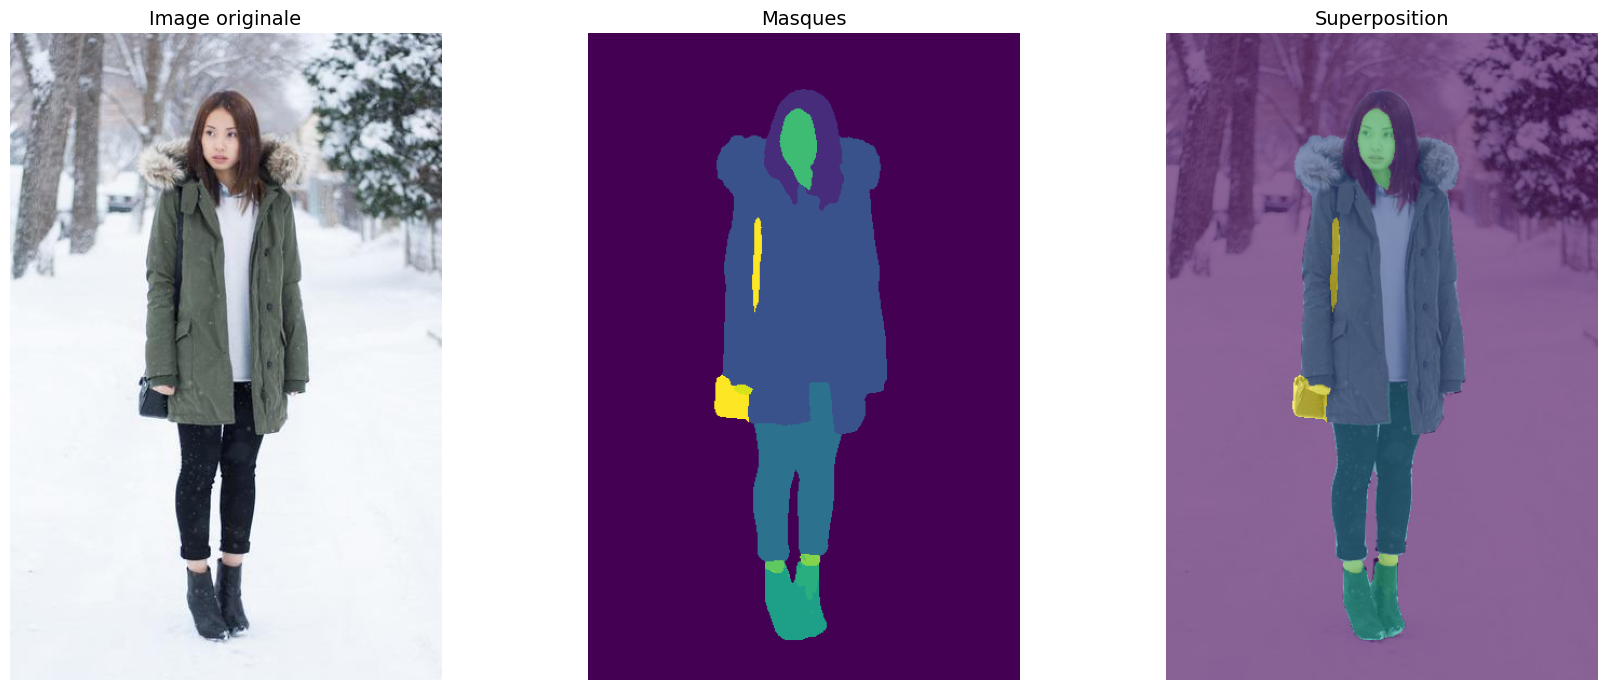

In [9]:
"""
    Ouvre l'image d'origine, puis si la réponse de l'API est une liste, 
    affiche trois visualisations : 
        - l'image originale 
        - les masques seuls
        - la superposition des masques sur l'image. 
"""

image = Image.open(single_image_path)

if isinstance(response, list):

    # Crée une figure avec 1 ligne et 3 colonnes
    # figsize pour gérer la taille de l'image
    _, axs = plt.subplots(1, 3, figsize=(18, 7))

    # Image
    axs[0].imshow(image)
    axs[0].set_title("Image originale", fontsize=14)
    axs[0].axis("off")

    # Masques
    axs[1].imshow(combined_mask)
    axs[1].set_title("Masques", fontsize=14)
    axs[1].axis("off")

    # Superposition
    axs[2].imshow(image)
    axs[2].imshow(combined_mask, alpha=0.6)
    axs[2].set_title("Superposition", fontsize=14)
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

else:
    print("Aucune image à traiter en batch.")